Installing Dependencies

In [1]:
import tensorflow as tf
import os 

I only have a cpu available so will use that

In [2]:
cpu = tf.config.experimental.list_physical_devices("CPU")
# tf.config.experimental.set_memory_growth(cpu[0],True)

Cleaning Images and removing noisy ones

In [3]:
import cv2
import imghdr

/var/folders/zl/f4yqhqcd1k7__tpz837j9c3m0000gn/T/ipykernel_973/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = "Data/"

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    if image_class!=".DS_Store":
        for picture in os.listdir(os.path.join(data_dir,image_class)):
            img_path = os.path.join(data_dir,image_class,picture)
            if os.path.getsize(img_path) < 50000:
                os.remove(img_path)



The below code removes all of the invalid extension images. To also identify corrput files which may appear as the corect tip but not in reality. 

In [7]:
for image_class in os.listdir(data_dir):
    if image_class!=".DS_Store":
        for picture in os.listdir(os.path.join(data_dir,image_class)):
            img_path = os.path.join(data_dir,image_class,picture)
            try:
                img = cv2.imread(img_path)
                tip = imghdr.what(img_path)
                if tip not in image_exts:
                    os.remove(img_path)
            except Exception as e:
                print(e)



Loading datasets

In [8]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 112 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()


In [12]:
batch = data_iterator.next()

In [13]:
#batch is numpy arrays of images and batch[1] is the labels 
batch[0].shape

(32, 256, 256, 3)

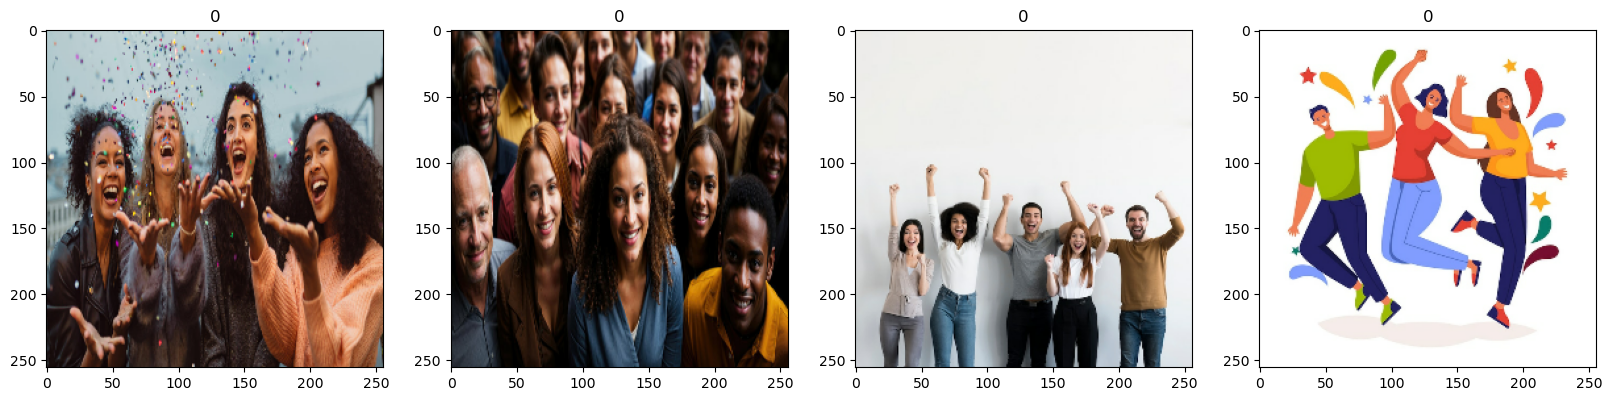

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocess Data

In [15]:
data = data.map(lambda x,y:(x/255,y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

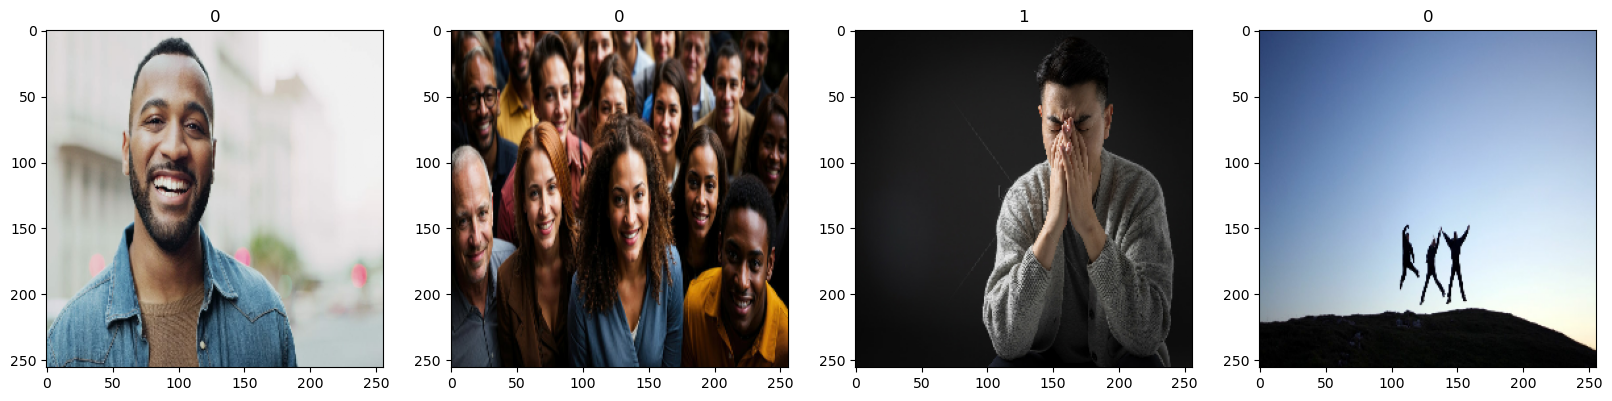

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Splitting Data

In [19]:
len(data)

4

In [20]:
train_size = 2
val_size = 1
test_size = 1

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [22]:
len(train)

2

Training the model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16,(3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1,activation='sigmoid'))


/Users/anirudhkrishnakumar/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
logdir = 'logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 740ms/step - accuracy: 0.5104 - loss: 1.3771 - val_accuracy: 0.5938 - val_loss: 0.6732
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.6250 - loss: 0.7437 - val_accuracy: 0.5000 - val_loss: 0.7864
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - accuracy: 0.4583 - loss: 0.8322 - val_accuracy: 0.5938 - val_loss: 0.6316
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step - accuracy: 0.6250 - loss: 0.6345 - val_accuracy: 0.5000 - val_loss: 0.6480
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 0.6771 - loss: 0.5064 - val_accuracy: 0.5938 - val_loss: 0.5746
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.7083 - loss: 0.4944 - val_accuracy: 0.9062 - val_loss: 0.4826
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.9062 - loss: 0.4617 - val_accuracy: 0.6875 - val_loss: 0.5431
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - accuracy: 0.8229 - loss: 0.3766 - val_accuracy: 0.5938 - val_loss:

Plotting the results

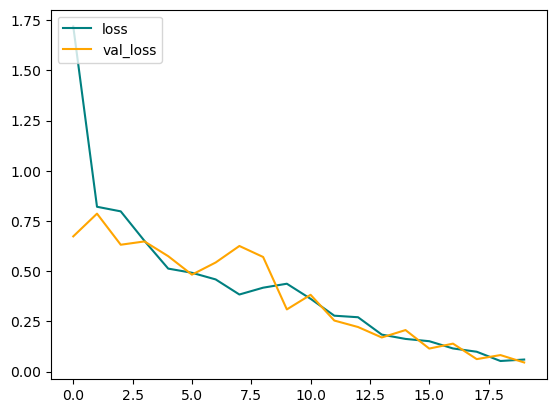

In [35]:
pfig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()


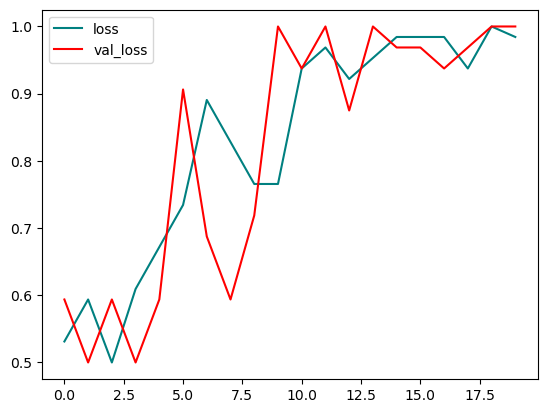

In [36]:
pfig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='red', label='val_loss')
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluating the performance of the application

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


2024-08-23 08:37:49.105769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1.0 1.0 1.0


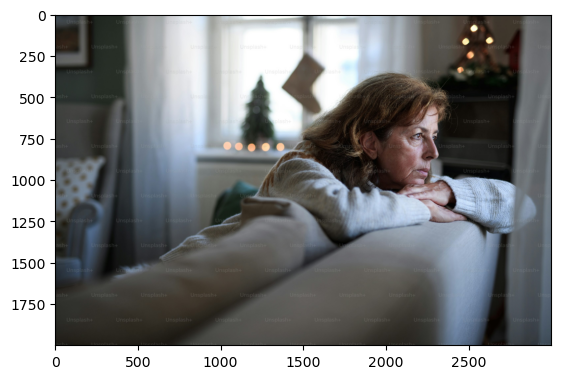

In [43]:
img = cv2.imread('sad_person.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [44]:
resize = tf.image.resize(img,(256,256))


In [45]:
np.expand_dims(resize,0)

array([[[[ 70.61963 ,  64.61963 ,  53.61963 ],
         [ 65.40625 ,  59.40625 ,  48.40625 ],
         [ 66.      ,  60.      ,  49.      ],
         ...,
         [ 98.40625 ,  96.40625 ,  95.40625 ],
         [ 99.      ,  97.      ,  96.      ],
         [ 98.59375 ,  97.59375 ,  93.59375 ]],

        [[ 73.21875 ,  67.21875 ,  56.21875 ],
         [ 71.21875 ,  65.21875 ,  54.21875 ],
         [ 70.      ,  64.      ,  53.      ],
         ...,
         [ 98.37744 ,  96.37744 ,  95.37744 ],
         [ 99.      ,  97.      ,  96.      ],
         [ 99.      ,  98.      ,  94.      ]],

        [[ 76.03125 ,  70.03125 ,  59.03125 ],
         [ 77.03125 ,  70.03125 ,  61.03125 ],
         [ 75.03125 ,  68.03125 ,  59.03125 ],
         ...,
         [101.      ,  99.      ,  98.      ],
         [100.      ,  98.      ,  97.      ],
         [100.      ,  98.      ,  97.      ]],

        ...,

        [[ 25.      ,  30.      ,  31.      ],
         [ 25.      ,  30.      ,  33.      ]

In [46]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Saving the model

In [48]:
from tensorflow.keras.models import load_model

In [50]:
model.save(os.path.join('models', 'happysadmodel.keras'))